# CHAPTER 6

#### On this chapter we will play a little bit with the technical indicators. Will see if we can increase the performance of this model.

##### Import libraries

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap
import datetime
import math as m

from ta import *

from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import seaborn as sns

from finta import TA


print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

Using TensorFlow backend.


Numpy version: 1.16.4
Pandas version: 0.24.2
Matplotlib version: 3.1.0
Sklearn version: 0.21.2
Keras version: 2.2.4


In [2]:
df = pd.read_csv('Hour/EURUSD.csv')
del df['Volume']
print(len(df))

101160


In [3]:
df['EMA_3'] =  ema(df['Close'], 3, fillna=True)
df['EMA_5'] =  ema(df['Close'], 5, fillna=True)
df['EMA_15'] =  ema(df['Close'], 15, fillna=True)
df['EMA_60'] =  ema(df['Close'], 60, fillna=True)
df['bb_high_indicator'] = donchian_channel_hband(df['Close'], n=20,fillna=True)
df['bb_low_indicator'] = donchian_channel_lband(df['Close'], n=20, fillna=True)
del df['Gmt time']


In [4]:
df.head(5)

,Open,High,Low,Close,EMA_3,EMA_5,EMA_15,EMA_60,bb_high_indicator,bb_low_indicator
0,1.12284,1.12338,1.12242,1.12305,1.123050,1.123050,1.123050,1.123050,1.123635,1.121825
1,1.12274,1.12302,1.12226,1.12241,1.122623,1.122666,1.122709,1.122725,1.123635,1.121825
2,1.12235,1.12235,1.12160,1.12169,1.122090,1.122204,1.122323,1.122368,1.123744,1.121023
3,1.12161,1.12314,1.12154,1.12258,1.122351,1.122360,1.122401,1.122424,1.123561,1.121304
4,1.12232,1.12262,1.12099,1.12140,1.121860,1.121991,1.122144,1.122205,1.123571,1.120881


In [5]:
def graph_data_ohlc(dataset):
    fig = plt.figure(figsize=(20,10))
    ax1 = plt.subplot2grid((1,1), (0,0))
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))
    
    ema3=dataset[:,[4]]
    ema5=dataset[:,[5]]
    ema15=dataset[:,[6]]
    ema60=dataset[:,[7]]
    
    bb_up=dataset[:,[8]]
    bb_down=dataset[:,[9]]
    
    
    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#075105', colordown='#AF141A')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax1.grid(True)
    plt.xlabel('Candle')
    plt.ylabel('Price')
    plt.title('Candlestick sample representation')
    plt.grid(False)
    
    plt.plot(ema3, color="red")
    plt.plot(ema5, color="blue")
    plt.plot(ema15, color="green")
    plt.plot(ema60, color="orange")
    
    plt.plot(bb_up, color="black")
    plt.plot(bb_down, color="black")
    
    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

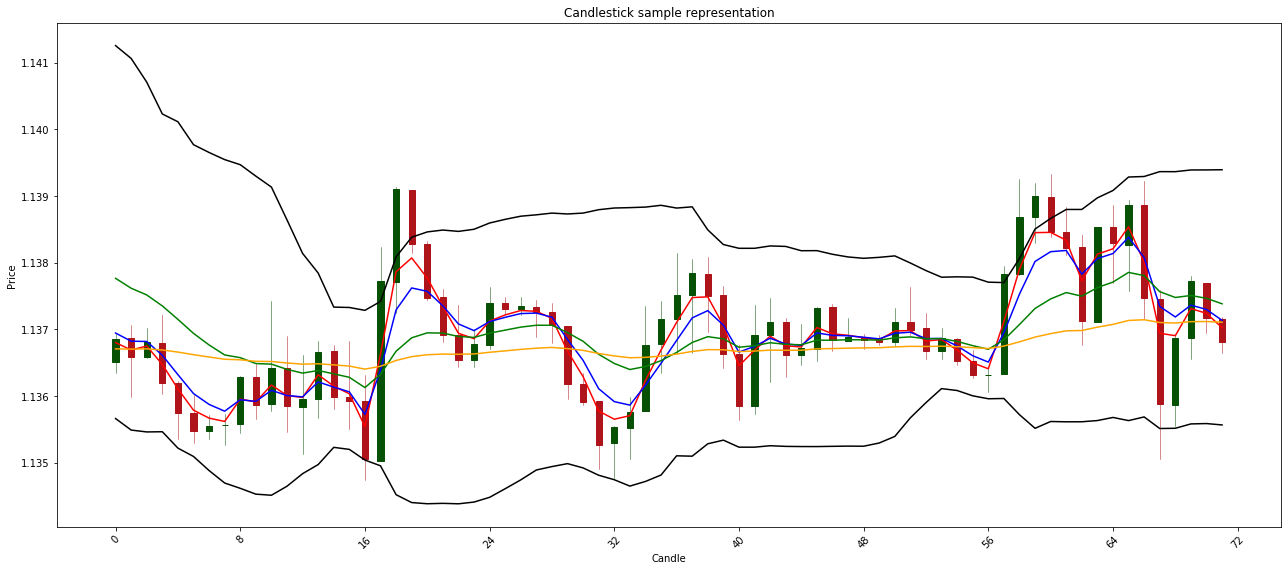

In [6]:
graph_data_ohlc(df.tail(72).values)

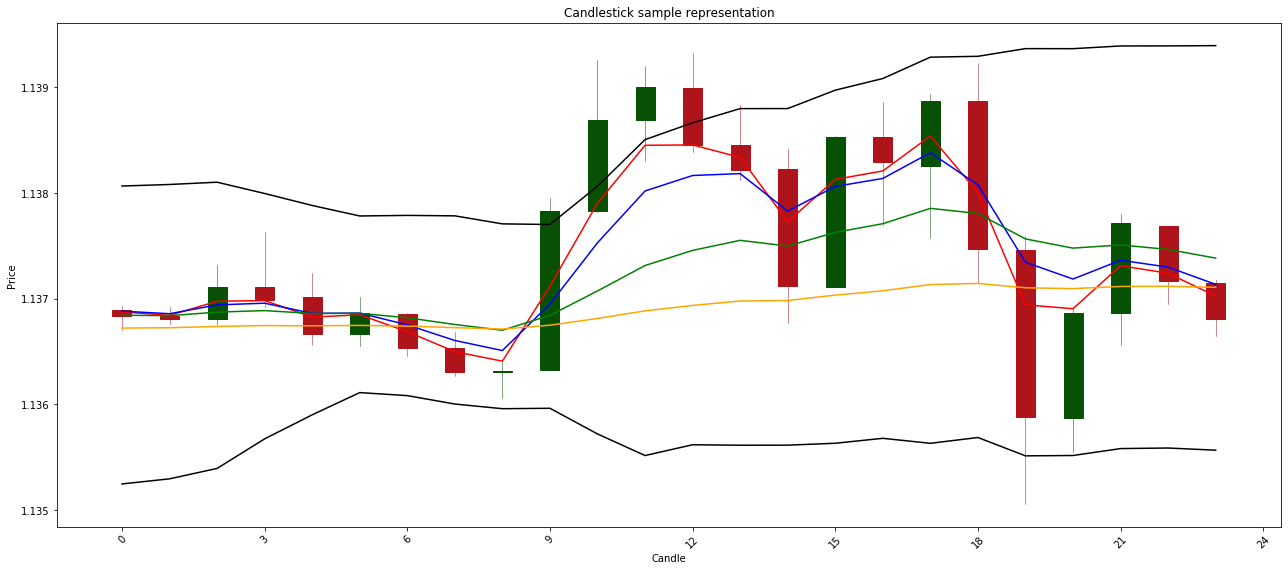

In [7]:
graph_data_ohlc(df.tail(24).values)

In [325]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6, ReturnDatetime=False):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]-1))
        targets = np.zeros((len(rows),2))
        
        if ReturnDatetime==True:dates = []
            
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            #print(data[indices])
            #print(data[indices][0][3])
            #testos = data[indices][1:] - data[indices][1:][0][4]
            
            testos = data[indices][:,1:11] - data[indices][1:][0][4]
          
            #print(testos)
            #samples[j] = data[indices]
            samples[j] = testos
            #print(data[indices])
            #print(str(data[rows[j]][4]) + ' and ' + str(data[rows[j] + delay][4] ))
            #print('------------')
            if data[rows[j]-1][4] < data[rows[j] + delay - 1][4]:targets[j] = np.array([1,0])
            else:targets[j] =np.array([0,1])
            
            
            if ReturnDatetime==True:dates.append(data[indices][lookback-1][0])
                
            #targets[j] = data[rows[j] + delay][1]
        if ReturnDatetime==True:
            #print(dates)
            yield samples, targets, dates
        else:
            yield samples, targets

In [326]:
float_data = pd.read_csv('Hour/EURUSD.csv')
del float_data['Volume']
print(len(float_data))
float_data['EMA_3'] =  ema(float_data['Close'], 3, fillna=True)
float_data['EMA_5'] =  ema(float_data['Close'], 5, fillna=True)
float_data['EMA_15'] =  ema(float_data['Close'], 15, fillna=True)
float_data['EMA_60'] =  ema(float_data['Close'], 60, fillna=True)
float_data['bb_high_indicator'] = donchian_channel_lband(float_data['Close'], n=20,  fillna=True)
float_data['bb_low_indicator'] = donchian_channel_hband(float_data['Close'], n=20, fillna=True)


101160


In [327]:
float_data.head(5)

,Gmt time,Open,High,Low,Close,EMA_3,EMA_5,EMA_15,EMA_60,bb_high_indicator,bb_low_indicator
0,04.05.2003 21:00:00.000,1.12284,1.12338,1.12242,1.12305,1.123050,1.123050,1.123050,1.123050,1.12305,1.12305
1,04.05.2003 22:00:00.000,1.12274,1.12302,1.12226,1.12241,1.122623,1.122666,1.122709,1.122725,1.12241,1.12305
2,04.05.2003 23:00:00.000,1.12235,1.12235,1.12160,1.12169,1.122090,1.122204,1.122323,1.122368,1.12169,1.12305
3,05.05.2003 00:00:00.000,1.12161,1.12314,1.12154,1.12258,1.122351,1.122360,1.122401,1.122424,1.12169,1.12305
4,05.05.2003 01:00:00.000,1.12232,1.12262,1.12099,1.12140,1.121860,1.121991,1.122144,1.122205,1.12140,1.12305


In [328]:
lookback = 120
step = 1
delay = 4
batch_size = 500

train_gen = generator(float_data.values,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=30000,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data.values,
                    lookback=lookback,
                    delay=delay,
                    min_index=30001,
                    max_index=60000,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data.values,
                     lookback=lookback,
                     delay=delay,
                     min_index=60001,
                     max_index=100000,
                     shuffle=False,
                     step=step,
                     batch_size=batch_size,
                     ReturnDatetime=True)

# Liczba kroków pobierania danych z obiektu val_gen 
# zapewniających przetworzenie całego walidacyjnego zbioru danych.
val_steps = (60000 - 30001 - lookback) // batch_size

# Liczba kroków pobierania danych z obiektu test_gen, 
# przy której przetworzony zostanie cały testowy zbiór danych.
test_steps = (len(float_data) - 60001 - lookback) // batch_size

In [329]:
def extract_from_generator(generator_item,return_batches):
    counter=0
    for gen_item in generator_item:
        if counter==0:
            X=gen_item[0]
            Y=gen_item[1]
            Dates=gen_item[2]
        else:
            X=np.concatenate((X, gen_item[0]), axis=0)
            Y=np.concatenate((Y, gen_item[1]), axis=0)
            Dates=np.concatenate((Dates, gen_item[2]), axis=0)
        counter=counter+1
        if counter>return_batches:break
    return X,Y,Dates

In [330]:
X,Y,Dates = extract_from_generator(test_gen,50)

NEXT CANDLE WILL BE: GREEN


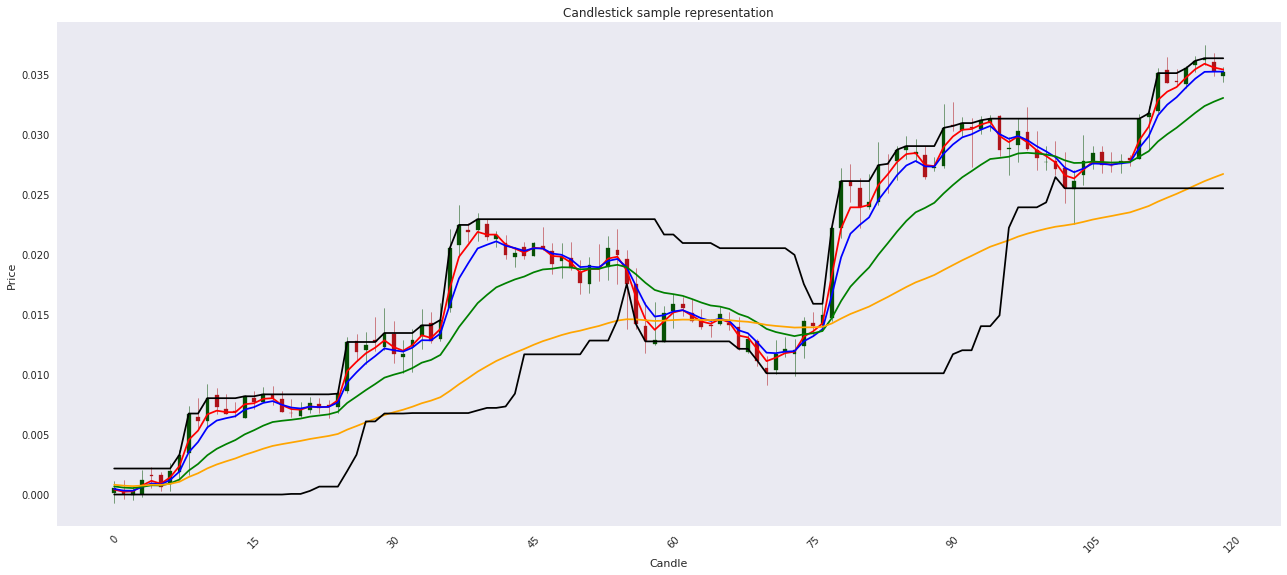

In [331]:
from IPython.display import clear_output
looping=0
while looping < 10:
    a = next(train_gen)
    counter=0
    for aa in a[0]:
            time.sleep(1) 
            clear_output()
            if a[1][counter][0] == 1: print('NEXT CANDLE WILL BE: GREEN')
            else: print('NEXT CANDLE WILL BE: RED')
            graph_data_ohlc(aa)
            counter=counter+1
            looping=looping+1
            if looping > 10: break

In [318]:
from keras import regularizers
from keras import layers

from keras.optimizers import RMSprop, Adam, SGD, Nadam

model = Sequential()  
model.add(layers.CuDNNLSTM(units = 64,return_sequences=True,input_shape = (24, float_data.shape[-1]-1)) )

model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(layers.CuDNNLSTM(units = 32,return_sequences=True)) 

model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(layers.CuDNNLSTM(units = 32,return_sequences=False)) 


model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(Dense(64)) 

model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dropout(0.5))

model.add(Dense(2)) 
model.add(layers.Activation('softmax'))
model.compile(optimizer=Nadam(lr=0.002),loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=60,
                              epochs=1000,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/1000
60/60 [==============================] - 15s 258ms/step - loss: 0.8759 - acc: 0.4965 - val_loss: 0.7012 - val_acc: 0.5011
Epoch 2/1000
60/60 [==============================] - 8s 141ms/step - loss: 0.7367 - acc: 0.5036 - val_loss: 0.6941 - val_acc: 0.5019
Epoch 3/1000
60/60 [==============================] - 9s 148ms/step - loss: 0.7092 - acc: 0.4996 - val_loss: 0.6943 - val_acc: 0.4973
Epoch 4/1000
60/60 [==============================] - 7s 124ms/step - loss: 0.6998 - acc: 0.4992 - val_loss: 0.7086 - val_acc: 0.5010
Epoch 5/1000
60/60 [==============================] - 8s 130ms/step - loss: 0.6964 - acc: 0.5019 - val_loss: 0.6965 - val_acc: 0.5037
Epoch 6/1000
60/60 [==============================] - 7s 124ms/step - loss: 0.6954 - acc: 0.5005 - val_loss: 0.6983 - val_acc: 0.4990
Epoch 7/1000
60/60 [==============================] - 7s 122ms/step - loss: 0.6942 - acc: 0.5042 - val_loss: 0.6934 - val_acc: 0.4972
Epoch 8/1000
60/60 [==============================] - 8s 125m

KeyboardInterrupt: 

In [ ]:
30000/500

In [ ]:
from plot_stats import get_model_insights

In [ ]:
model_stats = get_model_insights(model,history,0.43,X,Y,Dates)

In [ ]:
def graph_data_ohlc_indicators(dataset,pred_dataset,prediction_status,outcome_status):
    fig = plt.figure(figsize=(20,10))
    ax1 = plt.subplot2grid((3,1), (0,0))
    ax2 = plt.subplot2grid((3,1), (2,0))
    
    closep=dataset[:,[3]]
    highp=dataset[:,[1]]
    lowp=dataset[:,[2]]
    openp=dataset[:,[0]]
    date=range(len(closep))
    
    ema3=dataset[:,[4]]
    ema5=dataset[:,[5]]
    ema15=dataset[:,[6]]
    ema60=dataset[:,[7]]
    
    bb_up=dataset[:,[8]]
    bb_down=dataset[:,[9]]
    
    
    x = 0
    y = len(date)
    ohlc = []
    while x < y:
        append_me = date[x], openp[x], highp[x], lowp[x], closep[x]
        ohlc.append(append_me)
        x+=1
    candlestick_ohlc(ax1, ohlc, width=0.4, colorup='#075105', colordown='#AF141A')
    for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))

    
    ax1.plot(ema3, color="red")
    ax1.plot(ema5, color="blue")
    ax1.plot(ema15, color="green")
    ax1.plot(ema60, color="orange")
    
    ax1.plot(bb_up, color="black")
    ax1.plot(bb_down, color="black")
    
    print(ema3[0])

    ax2.set_title('MACD')
    #ax2.hist(range(len(ema3)),ema3, bins=20)
    ax2.xcorr(range(len(ema60)),ema60)

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
    plt.show()

In [ ]:
def model_chart_examples(model,X,Y,alpha,limit):

    alpha_percent = 1-alpha

    counter_generate=0
    counter_loop=0
    total_pred  = model.predict(X)
    for pred in total_pred:
        #prediction=model.predict(np.array([pred]))

        if pred[0] > alpha_percent:
            if Y[counter_loop][0] == 1:trade_status=1
            else: trade_status=0
            graph_data_ohlc_indicators(X[counter_loop],X[counter_loop+1],1,trade_status) 
            counter_generate=counter_generate+1
        if pred[1] > alpha_percent:  
            if Y[counter_loop][0] == 0:trade_status=1
            else: trade_status=0
            graph_data_ohlc_indicators(X[counter_loop],X[counter_loop+1],0,trade_status) 
            counter_generate=counter_generate+1

        counter_loop=counter_loop+1
        if counter_generate > limit: break

In [ ]:
model_chart_examples(model,X,Y,0.47,20)

In [319]:
import pandas as pd
import numpy as np
import random
import matplotlib.pylab as plt
import datetime
import locale
locale.setlocale(locale.LC_NUMERIC, "")


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

In [320]:
ASK_FNAME = "rtf/eurusd002-ask.rtf"
BID_FNAME = "rtf/eurusd002-BID.rtf"
WINDOW=90
FORECAST=45
EMB_SIZE=10
STEP=1  #best is 75
TRAIN_TEST_PERCENTAGE=0.9
SAVE_NAME = "classification_model.hdf5"
LOAD_NAME = "classification_model.hdf5"
ENABLE_CSV_OUTPUT = 1
NAME_CSV = "classification"
TRAINING = 1
TESTING = 0
NUMBER_EPOCHS = 10
TRADING_DAYS = 5

In [346]:
#MODEL DEFINITION
print ('initializing model..')
model = Sequential()
model.add(Convolution1D(input_shape = (120, float_data.shape[-1]-1),
                        nb_filter=32,
                        filter_length=8,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(nb_filter=16,
                        filter_length=8,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath=SAVE_NAME, verbose=1, save_best_only=True)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])




initializing model..


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(120, 10), filters=32, kernel_size=8, padding="same")`
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=16, kernel_size=8, padding="same")`
  


In [ ]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              verbose=1, 
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks=[reduce_lr, checkpointer],
                              shuffle=True)

Epoch 1/5
484/500 [============================>.] - ETA: 3s - loss: 0.7007 - acc: 0.5223

In [ ]:
model_stats = get_model_insights(model,history,0.19,X,Y,Dates)